<a href="https://colab.research.google.com/github/Revo2407/DeanPackage/blob/master/FraudDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches
import time

# Classifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import collections


# Other Libraries

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold
import warnings
warnings.filterwarnings("ignore")


In [3]:
# Load data 

from google.colab import files
uploaded = files.upload()

Saving training.csv to training (3).csv


In [0]:
import io
train = pd.read_csv(io.BytesIO(uploaded['training.csv']))
test = pd.read_csv(io.BytesIO(uploaded['test.csv']))
# Dataset is now stored in a Pandas Dataframe

In [58]:
train.head()

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult
0,TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,UGX,256,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.0,1000,2018-11-15T02:18:49Z,2,0
1,TransactionId_73770,BatchId_15642,AccountId_4841,SubscriptionId_3829,CustomerId_4406,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-20.0,20,2018-11-15T02:19:08Z,2,0
2,TransactionId_26203,BatchId_53941,AccountId_4229,SubscriptionId_222,CustomerId_4683,UGX,256,ProviderId_6,ProductId_1,airtime,ChannelId_3,500.0,500,2018-11-15T02:44:21Z,2,0
3,TransactionId_380,BatchId_102363,AccountId_648,SubscriptionId_2185,CustomerId_988,UGX,256,ProviderId_1,ProductId_21,utility_bill,ChannelId_3,20000.0,21800,2018-11-15T03:32:55Z,2,0
4,TransactionId_28195,BatchId_38780,AccountId_4841,SubscriptionId_3829,CustomerId_988,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-644.0,644,2018-11-15T03:34:21Z,2,0


In [59]:
train.describe()

,CountryCode,Amount,Value,PricingStrategy,FraudResult
count,95662.0,9.566200e+04,9.566200e+04,95662.000000,95662.000000
mean,256.0,6.717846e+03,9.900584e+03,2.255974,0.002018
std,0.0,1.233068e+05,1.231221e+05,0.732924,0.044872
min,256.0,-1.000000e+06,2.000000e+00,0.000000,0.000000
25%,256.0,-5.000000e+01,2.750000e+02,2.000000,0.000000
50%,256.0,1.000000e+03,1.000000e+03,2.000000,0.000000
75%,256.0,2.800000e+03,5.000000e+03,2.000000,0.000000
max,256.0,9.880000e+06,9.880000e+06,4.000000,1.000000


In [60]:
# Good No Null Values!

train.isnull().sum().max()

0

In [61]:
train.columns

Index(['TransactionId', 'BatchId', 'AccountId', 'SubscriptionId', 'CustomerId',
       'CurrencyCode', 'CountryCode', 'ProviderId', 'ProductId',
       'ProductCategory', 'ChannelId', 'Amount', 'Value',
       'TransactionStartTime', 'PricingStrategy', 'FraudResult'],
      dtype='object')

In [62]:
# The classes are heavily skewed

print('No Frauds', round(train['FraudResult'].value_counts()[0]/len(train) * 100,2), '% of the dataset')
print('Frauds', round(train['FraudResult'].value_counts()[1]/len(train) * 100,2), '% of the dataset')

No Frauds 99.8 % of the dataset
Frauds 0.2 % of the dataset


Text(0.5, 1.0, 'Class Distributions \n (0: No Fraud || 1: Fraud)')

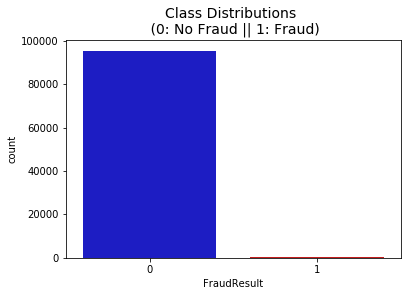

In [63]:
colors = ["#0101DF", "#DF0101"]

sns.countplot('FraudResult', data=train, palette=colors)
plt.title('Class Distributions \n (0: No Fraud || 1: Fraud)', fontsize=14)

In [64]:
train.shape

(95662, 16)

In [0]:
Fraud = train[train['FraudResult']==1]

Normal = train[train['FraudResult']==0]

In [66]:
Fraud.shape

(193, 16)

In [67]:
Normal.shape

(95469, 16)

In [68]:
Fraud.Amount.describe()

count    1.930000e+02
mean     1.535272e+06
std      2.100525e+06
min     -9.000000e+05
25%      5.000000e+05
50%      6.000000e+05
75%      2.000000e+06
max      9.880000e+06
Name: Amount, dtype: float64

In [69]:
Normal.Amount.describe()

count    9.546900e+04
mean     3.627723e+03
std      4.035711e+04
min     -1.000000e+06
25%     -5.000000e+01
50%      1.000000e+03
75%      2.500000e+03
max      2.400000e+06
Name: Amount, dtype: float64

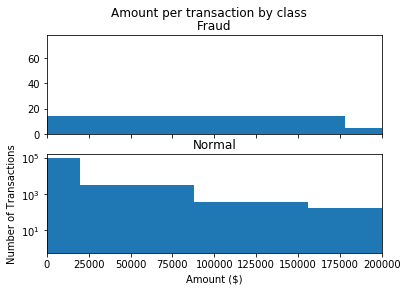

In [70]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Amount per transaction by class')
bins = 50
ax1.hist(Fraud.Amount, bins = bins)
ax1.set_title('Fraud')
ax2.hist(Normal.Amount, bins = bins)
ax2.set_title('Normal')
plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((100, 200000))
plt.yscale('log')
plt.show()

In [0]:
# Since most of our data has already been scaled we should scale the columns that are left to scale (Amount and Time)
from sklearn.preprocessing import StandardScaler, RobustScaler

# RobustScaler is less prone to outliers.

std_scaler = StandardScaler()
rob_scaler = RobustScaler()

train['scaled_amount'] = rob_scaler.fit_transform(train['Amount'].values.reshape(-1,1))
train['scaled_countrycode'] = rob_scaler.fit_transform(train['CountryCode'].values.reshape(-1,1))
train['scaled_pricing_Strategy'] = rob_scaler.fit_transform(train['PricingStrategy'].values.reshape(-1,1))
train['scaled_value'] = rob_scaler.fit_transform(train['Value'].values.reshape(-1,1))



train.drop(['Amount', 'CountryCode', 'PricingStrategy', 'Value'], axis=1, inplace=True)

In [72]:
train.head()

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,ProviderId,ProductId,ProductCategory,ChannelId,TransactionStartTime,FraudResult,scaled_amount,scaled_countrycode,scaled_pricing_Strategy,scaled_value
0,TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,UGX,ProviderId_6,ProductId_10,airtime,ChannelId_3,2018-11-15T02:18:49Z,0,0.000000,0.0,0.0,0.000000
1,TransactionId_73770,BatchId_15642,AccountId_4841,SubscriptionId_3829,CustomerId_4406,UGX,ProviderId_4,ProductId_6,financial_services,ChannelId_2,2018-11-15T02:19:08Z,0,-0.357895,0.0,0.0,-0.207407
2,TransactionId_26203,BatchId_53941,AccountId_4229,SubscriptionId_222,CustomerId_4683,UGX,ProviderId_6,ProductId_1,airtime,ChannelId_3,2018-11-15T02:44:21Z,0,-0.175439,0.0,0.0,-0.105820
3,TransactionId_380,BatchId_102363,AccountId_648,SubscriptionId_2185,CustomerId_988,UGX,ProviderId_1,ProductId_21,utility_bill,ChannelId_3,2018-11-15T03:32:55Z,0,6.666667,0.0,0.0,4.402116
4,TransactionId_28195,BatchId_38780,AccountId_4841,SubscriptionId_3829,CustomerId_988,UGX,ProviderId_4,ProductId_6,financial_services,ChannelId_2,2018-11-15T03:34:21Z,0,-0.576842,0.0,0.0,-0.075344


In [0]:
train.drop(['BatchId','AccountId','SubscriptionId','CustomerId','ProviderId','ChannelId','ProductId'] ,axis =1 , inplace = True)

In [0]:
# Remap all ID columns to be used
train['TransactionId'].replace(regex=True,inplace=True,to_replace=r'\D',value=r'')
train['BatchId'].replace(regex=True,inplace=True,to_replace=r'\D',value=r'')
train['AccountId'].replace(regex=True,inplace=True,to_replace=r'\D',value=r'')
train['SubscriptionId'].replace(regex=True,inplace=True,to_replace=r'\D',value=r'')
train['CustomerId'].replace(regex=True,inplace=True,to_replace=r'\D',value=r'')
train['ProviderId'].replace(regex=True,inplace=True,to_replace=r'\D',value=r'')
train['ChannelId'].replace(regex=True,inplace=True,to_replace=r'\D',value=r'')
train['ProductId'].replace(regex=True,inplace=True,to_replace=r'\D',value=r'')

In [74]:
train.head()

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,ProviderId,ProductId,ProductCategory,ChannelId,TransactionStartTime,FraudResult,scaled_amount,scaled_countrycode,scaled_pricing_Strategy,scaled_value
0,76871,36123,3957,887,4406,UGX,6,10,airtime,3,2018-11-15T02:18:49Z,0,0.000000,0.0,0.0,0.000000
1,73770,15642,4841,3829,4406,UGX,4,6,financial_services,2,2018-11-15T02:19:08Z,0,-0.357895,0.0,0.0,-0.207407
2,26203,53941,4229,222,4683,UGX,6,1,airtime,3,2018-11-15T02:44:21Z,0,-0.175439,0.0,0.0,-0.105820
3,380,102363,648,2185,988,UGX,1,21,utility_bill,3,2018-11-15T03:32:55Z,0,6.666667,0.0,0.0,4.402116
4,28195,38780,4841,3829,988,UGX,4,6,financial_services,2,2018-11-15T03:34:21Z,0,-0.576842,0.0,0.0,-0.075344


In [75]:
train.dtypes

TransactionId               object
BatchId                     object
AccountId                   object
SubscriptionId              object
CustomerId                  object
CurrencyCode                object
ProviderId                  object
ProductId                   object
ProductCategory             object
ChannelId                   object
TransactionStartTime        object
FraudResult                  int64
scaled_amount              float64
scaled_countrycode         float64
scaled_pricing_Strategy    float64
scaled_value               float64
dtype: object

In [0]:
train = train.astype({'TransactionId': int, 'BatchId': int, 'AccountId': int, 'SubscriptionId': int, 'CustomerId': int, 'ProviderId': int, 'ProductId':int, 'ChannelId':int })

In [77]:
train.dtypes

TransactionId                int64
BatchId                      int64
AccountId                    int64
SubscriptionId               int64
CustomerId                   int64
CurrencyCode                object
ProviderId                   int64
ProductId                    int64
ProductCategory             object
ChannelId                    int64
TransactionStartTime        object
FraudResult                  int64
scaled_amount              float64
scaled_countrycode         float64
scaled_pricing_Strategy    float64
scaled_value               float64
dtype: object

In [0]:
train.drop(['CurrencyCode'] ,axis =1 , inplace = True)

In [0]:
train['TransactionTime'] = pd.to_datetime(train['TransactionStartTime'])

In [0]:
train.drop(['TransactionStartTime'] ,axis =1 , inplace = True)

In [0]:
train.set_index('TransactionTime', inplace=True)

In [82]:
train.dtypes

TransactionId                int64
BatchId                      int64
AccountId                    int64
SubscriptionId               int64
CustomerId                   int64
ProviderId                   int64
ProductId                    int64
ProductCategory             object
ChannelId                    int64
FraudResult                  int64
scaled_amount              float64
scaled_countrycode         float64
scaled_pricing_Strategy    float64
scaled_value               float64
dtype: object

In [83]:
train.head()

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,ProviderId,ProductId,ProductCategory,ChannelId,FraudResult,scaled_amount,scaled_countrycode,scaled_pricing_Strategy,scaled_value
TransactionTime,,,,,,,,,,,,,,
2018-11-15 02:18:49+00:00,76871,36123,3957,887,4406,6,10,airtime,3,0,0.000000,0.0,0.0,0.000000
2018-11-15 02:19:08+00:00,73770,15642,4841,3829,4406,4,6,financial_services,2,0,-0.357895,0.0,0.0,-0.207407
2018-11-15 02:44:21+00:00,26203,53941,4229,222,4683,6,1,airtime,3,0,-0.175439,0.0,0.0,-0.105820
2018-11-15 03:32:55+00:00,380,102363,648,2185,988,1,21,utility_bill,3,0,6.666667,0.0,0.0,4.402116
2018-11-15 03:34:21+00:00,28195,38780,4841,3829,988,4,6,financial_services,2,0,-0.576842,0.0,0.0,-0.075344


In [0]:
# Get dummies
train = pd.get_dummies(train, prefix_sep='_', drop_first=True)


In [85]:
train.head()

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,ProviderId,ProductId,ChannelId,FraudResult,scaled_amount,scaled_countrycode,scaled_pricing_Strategy,scaled_value,ProductCategory_data_bundles,ProductCategory_financial_services,ProductCategory_movies,ProductCategory_other,ProductCategory_ticket,ProductCategory_transport,ProductCategory_tv,ProductCategory_utility_bill
TransactionTime,,,,,,,,,,,,,,,,,,,,,
2018-11-15 02:18:49+00:00,76871,36123,3957,887,4406,6,10,3,0,0.000000,0.0,0.0,0.000000,0,0,0,0,0,0,0,0
2018-11-15 02:19:08+00:00,73770,15642,4841,3829,4406,4,6,2,0,-0.357895,0.0,0.0,-0.207407,0,1,0,0,0,0,0,0
2018-11-15 02:44:21+00:00,26203,53941,4229,222,4683,6,1,3,0,-0.175439,0.0,0.0,-0.105820,0,0,0,0,0,0,0,0
2018-11-15 03:32:55+00:00,380,102363,648,2185,988,1,21,3,0,6.666667,0.0,0.0,4.402116,0,0,0,0,0,0,0,1
2018-11-15 03:34:21+00:00,28195,38780,4841,3829,988,4,6,2,0,-0.576842,0.0,0.0,-0.075344,0,1,0,0,0,0,0,0


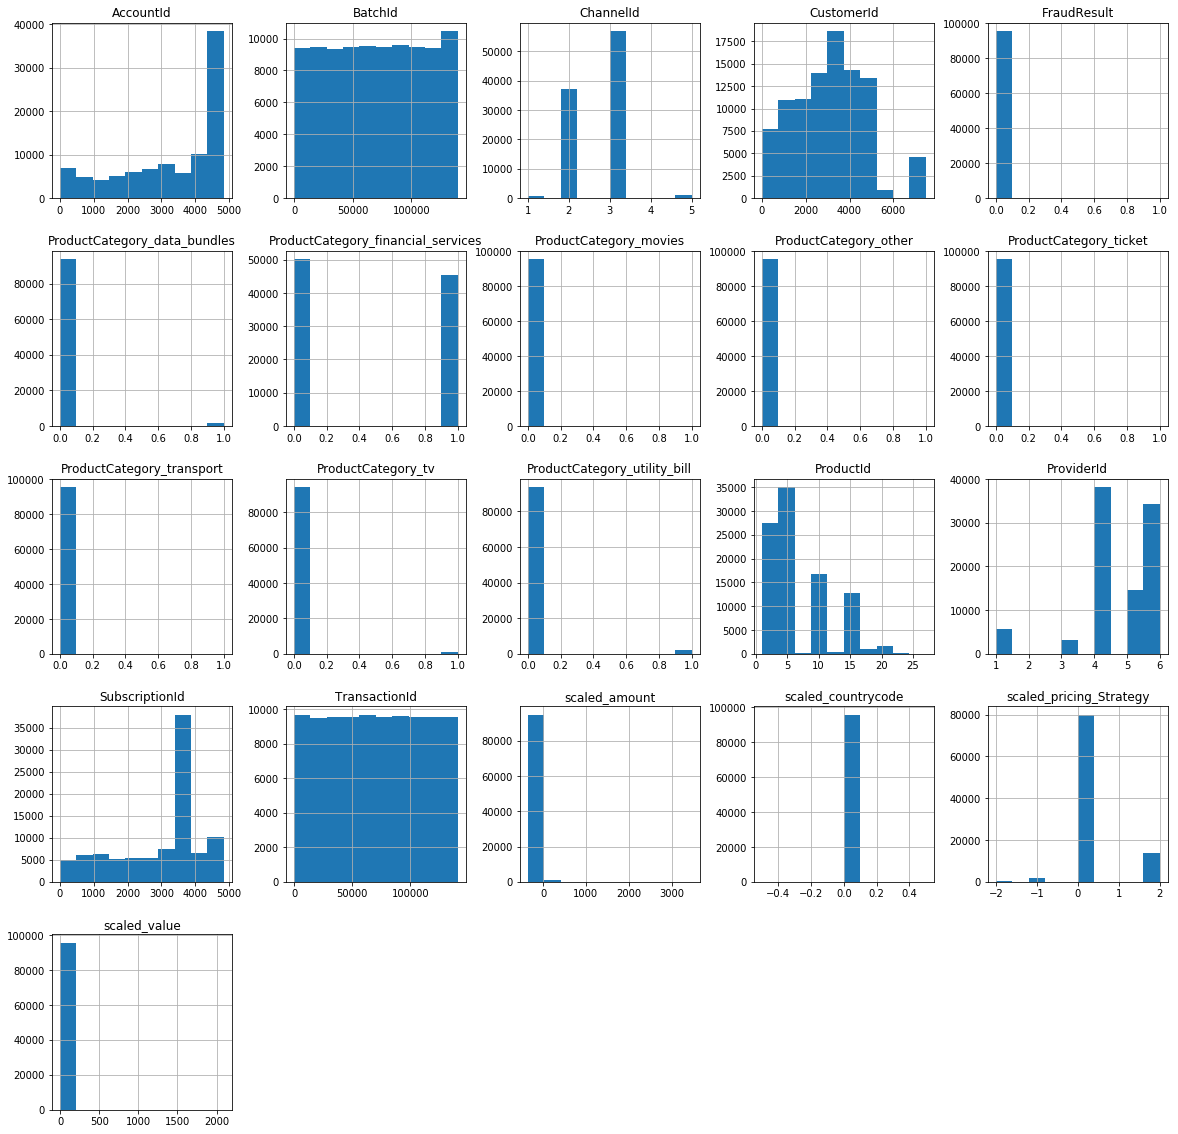

In [86]:
train.hist(figsize=(20,20))
plt.show()

In [87]:
train.head()

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,ProviderId,ProductId,ChannelId,FraudResult,scaled_amount,scaled_countrycode,scaled_pricing_Strategy,scaled_value,ProductCategory_data_bundles,ProductCategory_financial_services,ProductCategory_movies,ProductCategory_other,ProductCategory_ticket,ProductCategory_transport,ProductCategory_tv,ProductCategory_utility_bill
TransactionTime,,,,,,,,,,,,,,,,,,,,,
2018-11-15 02:18:49+00:00,76871,36123,3957,887,4406,6,10,3,0,0.000000,0.0,0.0,0.000000,0,0,0,0,0,0,0,0
2018-11-15 02:19:08+00:00,73770,15642,4841,3829,4406,4,6,2,0,-0.357895,0.0,0.0,-0.207407,0,1,0,0,0,0,0,0
2018-11-15 02:44:21+00:00,26203,53941,4229,222,4683,6,1,3,0,-0.175439,0.0,0.0,-0.105820,0,0,0,0,0,0,0,0
2018-11-15 03:32:55+00:00,380,102363,648,2185,988,1,21,3,0,6.666667,0.0,0.0,4.402116,0,0,0,0,0,0,0,1
2018-11-15 03:34:21+00:00,28195,38780,4841,3829,988,4,6,2,0,-0.576842,0.0,0.0,-0.075344,0,1,0,0,0,0,0,0


In [88]:
print('No Frauds', round(train['FraudResult'].value_counts()[0]/len(train) * 100,2), '% of the dataset')
print('Frauds', round(train['FraudResult'].value_counts()[1]/len(train) * 100,2), '% of the dataset')

X = train.drop('FraudResult', axis=1)
y = train['FraudResult']

sss = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

for train_index, test_index in sss.split(X, y):
    print("Train:", train_index, "Test:", test_index)
    original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]

# We already have X_train and y_train for undersample data thats why I am using original to distinguish and to not overwrite these variables.
# original_Xtrain, original_Xtest, original_ytrain, original_ytest = train_test_split(X, y, test_size=0.2, random_state=42)

# Turn into an array
original_Xtrain = original_Xtrain.values
original_Xtest = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest = original_ytest.values

# See if both the train and test label distribution are similarly distributed
train_unique_label, train_counts_label = np.unique(original_ytrain, return_counts=True)
test_unique_label, test_counts_label = np.unique(original_ytest, return_counts=True)
print('-' * 100)

print('Label Distributions: \n')
print(train_counts_label/ len(original_ytrain))
print(test_counts_label/ len(original_ytest))



No Frauds 99.8 % of the dataset
Frauds 0.2 % of the dataset
Train: [19127 19128 19129 ... 95659 95660 95661] Test: [    0     1     2 ... 22377 22820 23157]
Train: [    0     1     2 ... 95659 95660 95661] Test: [19127 19128 19129 ... 47285 48212 48287]
Train: [    0     1     2 ... 95659 95660 95661] Test: [38251 38252 38253 ... 70047 70051 70218]
Train: [    0     1     2 ... 95659 95660 95661] Test: [57373 57374 57375 ... 82314 82318 82333]
Train: [    0     1     2 ... 82314 82318 82333] Test: [76503 76504 76505 ... 95659 95660 95661]
----------------------------------------------------------------------------------------------------
Label Distributions: 

[0.99797468 0.00202532]
[0.9980137 0.0019863]


In [89]:
# Lets shuffle the data before creating the subsamples

train = train.sample(frac=1)

# amount of fraud classes 193 rows.
fraud_df = train.loc[train['FraudResult'] == 1]
non_fraud_df = train.loc[train['FraudResult'] == 0][:193]

normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

# Shuffle dataframe rows
new_df = normal_distributed_df.sample(frac=1, random_state=42)

new_df.head()

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,ProviderId,ProductId,ChannelId,FraudResult,scaled_amount,scaled_countrycode,scaled_pricing_Strategy,scaled_value,ProductCategory_data_bundles,ProductCategory_financial_services,ProductCategory_movies,ProductCategory_other,ProductCategory_ticket,ProductCategory_transport,ProductCategory_tv,ProductCategory_utility_bill
TransactionTime,,,,,,,,,,,,,,,,,,,,,
2018-12-21 09:19:26+00:00,74153,40767,4841,3829,4109,4,6,2,0,-0.352632,0.0,0.0,-0.210582,0,1,0,0,0,0,0,0
2018-12-16 09:44:03+00:00,122313,23063,318,3087,647,1,15,3,0,5.087719,0.0,0.0,3.068783,0,1,0,0,0,0,0,0
2018-12-11 05:54:29+00:00,32870,84247,777,539,1122,1,15,3,1,648.771930,0.0,0.0,391.322751,0,1,0,0,0,0,0,0
2018-12-21 20:45:28+00:00,83511,117382,222,3419,546,6,3,3,0,3.157895,0.0,0.0,1.904762,0,0,0,0,0,0,0,0
2019-02-12 21:31:21+00:00,33086,40160,1909,2496,2303,3,15,3,1,175.087719,0.0,0.0,105.608466,0,1,0,0,0,0,0,0


Distribution of the Classes in the subsample dataset
1    0.5
0    0.5
Name: FraudResult, dtype: float64


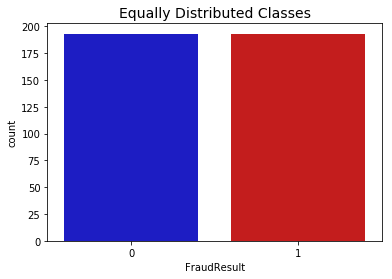

In [90]:
print('Distribution of the Classes in the subsample dataset')
print(new_df['FraudResult'].value_counts()/len(new_df))


sns.countplot('FraudResult', data=new_df, palette=colors)
plt.title('Equally Distributed Classes', fontsize=14)
plt.show()

In [91]:
# New_df is from the random undersample data (fewer instances)
X = new_df.drop('FraudResult', axis=1)
y = new_df['FraudResult']


# T-SNE Implementation
t0 = time.time()
X_reduced_tsne = TSNE(n_components=2, random_state=42).fit_transform(X.values)
t1 = time.time()
print("T-SNE took {:.2} s".format(t1 - t0))

# PCA Implementation
t0 = time.time()
X_reduced_pca = PCA(n_components=2, random_state=42).fit_transform(X.values)
t1 = time.time()
print("PCA took {:.2} s".format(t1 - t0))

# TruncatedSVD
t0 = time.time()
X_reduced_svd = TruncatedSVD(n_components=2, algorithm='randomized', random_state=42).fit_transform(X.values)
t1 = time.time()
print("Truncated SVD took {:.2} s".format(t1 - t0))

T-SNE took 2.2 s
PCA took 0.0041 s
Truncated SVD took 0.0032 s


In [0]:
# Undersampling before cross validating (prone to overfit)
X = new_df.drop('FraudResult', axis=1)
y = new_df['FraudResult']

In [0]:
# Our data is already scaled we should split our training and test sets
from sklearn.model_selection import train_test_split

# This is explicitly used for undersampling.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [0]:
# Turn the values into an array for feeding the classification algorithms.
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

In [0]:
# Let's implement simple classifiers

classifiers = {
    "LogisiticRegression": LogisticRegression(),
    "DecisionTreeClassifier": DecisionTreeClassifier()
}

In [110]:
# Wow our scores are getting even high scores even when applying cross validation.
from sklearn.model_selection import cross_val_score


for key, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    training_score = cross_val_score(classifier, X_train, y_train, cv=5)
    print("Classifiers: ", classifier.__class__.__name__, "Has a training score of", round(training_score.mean(), 2) * 100, "% accuracy score")

Classifiers:  LogisticRegression Has a training score of 98.0 % accuracy score
Classifiers:  DecisionTreeClassifier Has a training score of 98.0 % accuracy score


In [0]:
#Use GridSearchCV to find the best parameters.
from sklearn.model_selection import GridSearchCV


# Logistic Regression 
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1]}



grid_log_reg = GridSearchCV(LogisticRegression(), log_reg_params)
grid_log_reg.fit(X_train, y_train)
# We automatically get the logistic regression with the best parameters.
log_reg = grid_log_reg.best_estimator_

In [113]:
# Overfitting Case

log_reg_score = cross_val_score(log_reg, X_train, y_train, cv=5)
print('Logistic Regression Cross Validation Score: ', round(log_reg_score.mean() * 100, 2).astype(str) + '%')


Logistic Regression Cross Validation Score:  97.73%


In [104]:
# We will undersample during cross validating
undersample_X = train.drop('FraudResult', axis=1)
undersample_y = train['FraudResult']

for train_index, test_index in sss.split(undersample_X, undersample_y):
    print("Train:", train_index, "Test:", test_index)
    undersample_Xtrain, undersample_Xtest = undersample_X.iloc[train_index], undersample_X.iloc[test_index]
    undersample_ytrain, undersample_ytest = undersample_y.iloc[train_index], undersample_y.iloc[test_index]
    
undersample_Xtrain = undersample_Xtrain.values
undersample_Xtest = undersample_Xtest.values
undersample_ytrain = undersample_ytrain.values
undersample_ytest = undersample_ytest.values 

undersample_accuracy = []
undersample_precision = []
undersample_recall = []
undersample_f1 = []
undersample_auc = []

# Implementing NearMiss Technique 
# Distribution of NearMiss (Just to see how it distributes the labels we won't use these variables)
X_nearmiss, y_nearmiss = NearMiss().fit_sample(undersample_X.values, undersample_y.values)
print('NearMiss Label Distribution: {}'.format(Counter(y_nearmiss)))
# Cross Validating the right way
for train, test in sss.split(undersample_Xtrain, undersample_ytrain):
    undersample_pipeline = imbalanced_make_pipeline(NearMiss(sampling_strategy='majority'), log_reg) # SMOTE happens during Cross Validation not before..
    undersample_model = undersample_pipeline.fit(undersample_Xtrain[train], undersample_ytrain[train])
    undersample_prediction = undersample_model.predict(undersample_Xtrain[test])
    
    undersample_accuracy.append(undersample_pipeline.score(original_Xtrain[test], original_ytrain[test]))
    undersample_precision.append(precision_score(original_ytrain[test], undersample_prediction))
    undersample_recall.append(recall_score(original_ytrain[test], undersample_prediction))
    undersample_f1.append(f1_score(original_ytrain[test], undersample_prediction))
    undersample_auc.append(roc_auc_score(original_ytrain[test], undersample_prediction))

AttributeError: ignored

In [0]:
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_predict
# Create a DataFrame with all the scores and the classifiers names.

log_reg_pred = cross_val_predict(log_reg, X_train, y_train, cv=5,
                             method="decision_function")



In [117]:
from sklearn.metrics import roc_auc_score

print('Logistic Regression: ', roc_auc_score(y_train, log_reg_pred))


Logistic Regression:  0.9923651242249125


In [0]:
from sklearn.metrics import precision_recall_curve

precision, recall, threshold = precision_recall_curve(y_train, log_reg_pred)

In [119]:
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score
y_pred = log_reg.predict(X_train)

# Overfitting Case
print('---' * 45)
print('Overfitting: \n')
print('Recall Score: {:.2f}'.format(recall_score(y_train, y_pred)))
print('Precision Score: {:.2f}'.format(precision_score(y_train, y_pred)))
print('F1 Score: {:.2f}'.format(f1_score(y_train, y_pred)))
print('Accuracy Score: {:.2f}'.format(accuracy_score(y_train, y_pred)))
print('---' * 45)

# How it should look like
print('---' * 45)
print('How it should be:\n')
print("Accuracy Score: {:.2f}".format(np.mean(undersample_accuracy)))
print("Precision Score: {:.2f}".format(np.mean(undersample_precision)))
print("Recall Score: {:.2f}".format(np.mean(undersample_recall)))
print("F1 Score: {:.2f}".format(np.mean(undersample_f1)))
print('---' * 45)

---------------------------------------------------------------------------------------------------------------------------------------
Overfitting: 

Recall Score: 0.97
Precision Score: 0.99
F1 Score: 0.98
Accuracy Score: 0.98
---------------------------------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------------------------------
How it should be:

Accuracy Score: 0.89
Precision Score: 0.00
Recall Score: 0.12
F1 Score: 0.01
---------------------------------------------------------------------------------------------------------------------------------------


In [0]:
undersample_y_score = log_reg.decision_function(original_Xtest)

In [121]:
from sklearn.metrics import average_precision_score

undersample_average_precision = average_precision_score(original_ytest, undersample_y_score)

print('Average precision-recall score: {0:0.2f}'.format(
      undersample_average_precision))

Average precision-recall score: 0.84


In [0]:
# SMOTE Technique (OverSampling) After splitting and Cross Validating
sm = SMOTE(ratio='minority', random_state=42)
# Xsm_train, ysm_train = sm.fit_sample(X_train, y_train)


# This will be the data were we are going to 
Xsm_train, ysm_train = sm.fit_sample(original_Xtrain, original_ytrain)

In [123]:
# We Improve the score by 2% points approximately 
# Implement GridSearchCV and the other models.

# Logistic Regression
t0 = time.time()
log_reg_sm = grid_log_reg.best_estimator_
log_reg_sm.fit(Xsm_train, ysm_train)
t1 = time.time()
print("Fitting oversample data took :{} sec".format(t1 - t0))

Fitting oversample data took :2.617488145828247 sec


In [0]:
from sklearn.metrics import confusion_matrix

# Logistic Regression fitted using SMOTE technique
y_pred_log_reg = log_reg_sm.predict(X_test)

log_reg_cf = confusion_matrix(y_test, y_pred_log_reg)

In [127]:
from sklearn.metrics import classification_report


print('Logistic Regression:')
print(classification_report(y_test, y_pred_log_reg))




Logistic Regression:
              precision    recall  f1-score   support

           0       0.93      1.00      0.97        42
           1       1.00      0.92      0.96        36

    accuracy                           0.96        78
   macro avg       0.97      0.96      0.96        78
weighted avg       0.96      0.96      0.96        78



In [131]:
# Load data 

from google.colab import files
uploaded = files.upload()
test = pd.read_csv(io.BytesIO(uploaded['test.csv']))

Saving test.csv to test (1).csv


In [0]:
test = pd.read_csv(io.BytesIO(uploaded['test.csv']))

In [218]:
test.head()

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy
0,TransactionId_50600,BatchId_35028,AccountId_2441,SubscriptionId_4426,CustomerId_2857,UGX,256,ProviderId_5,ProductId_3,airtime,ChannelId_3,1000.0,1000,2019-02-13T10:01:40Z,4
1,TransactionId_95109,BatchId_45139,AccountId_3439,SubscriptionId_2643,CustomerId_3874,UGX,256,ProviderId_5,ProductId_15,financial_services,ChannelId_3,2000.0,2000,2019-02-13T10:02:12Z,2
2,TransactionId_47357,BatchId_74887,AccountId_4841,SubscriptionId_3829,CustomerId_2857,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-50.0,50,2019-02-13T10:02:30Z,2
3,TransactionId_28185,BatchId_11025,AccountId_2685,SubscriptionId_4626,CustomerId_3105,UGX,256,ProviderId_5,ProductId_10,airtime,ChannelId_3,3000.0,3000,2019-02-13T10:02:38Z,4
4,TransactionId_22140,BatchId_29804,AccountId_4841,SubscriptionId_3829,CustomerId_3105,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-60.0,60,2019-02-13T10:02:58Z,2


In [0]:
# Since most of our data has already been scaled we should scale the columns that are left to scale (Amount and Time)
from sklearn.preprocessing import StandardScaler, RobustScaler

# RobustScaler is less prone to outliers.

std_scaler = StandardScaler()
rob_scaler = RobustScaler()

test['scaled_amount'] = rob_scaler.fit_transform(test['Amount'].values.reshape(-1,1))
test['scaled_countrycode'] = rob_scaler.fit_transform(test['CountryCode'].values.reshape(-1,1))
test['scaled_pricing_Strategy'] = rob_scaler.fit_transform(test['PricingStrategy'].values.reshape(-1,1))
test['scaled_value'] = rob_scaler.fit_transform(test['Value'].values.reshape(-1,1))



test.drop(['Amount', 'CountryCode', 'PricingStrategy', 'Value'], axis=1, inplace=True)

In [220]:
test.head()

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,ProviderId,ProductId,ProductCategory,ChannelId,TransactionStartTime,scaled_amount,scaled_countrycode,scaled_pricing_Strategy,scaled_value
0,TransactionId_50600,BatchId_35028,AccountId_2441,SubscriptionId_4426,CustomerId_2857,UGX,ProviderId_5,ProductId_3,airtime,ChannelId_3,2019-02-13T10:01:40Z,0.000000,0.0,2.0,-0.042553
1,TransactionId_95109,BatchId_45139,AccountId_3439,SubscriptionId_2643,CustomerId_3874,UGX,ProviderId_5,ProductId_15,financial_services,ChannelId_3,2019-02-13T10:02:12Z,0.198020,0.0,0.0,0.170213
2,TransactionId_47357,BatchId_74887,AccountId_4841,SubscriptionId_3829,CustomerId_2857,UGX,ProviderId_4,ProductId_6,financial_services,ChannelId_2,2019-02-13T10:02:30Z,-0.207921,0.0,0.0,-0.244681
3,TransactionId_28185,BatchId_11025,AccountId_2685,SubscriptionId_4626,CustomerId_3105,UGX,ProviderId_5,ProductId_10,airtime,ChannelId_3,2019-02-13T10:02:38Z,0.396040,0.0,2.0,0.382979
4,TransactionId_22140,BatchId_29804,AccountId_4841,SubscriptionId_3829,CustomerId_3105,UGX,ProviderId_4,ProductId_6,financial_services,ChannelId_2,2019-02-13T10:02:58Z,-0.209901,0.0,0.0,-0.242553


In [0]:
test.drop(['BatchId','AccountId','SubscriptionId','CustomerId','ProviderId','ChannelId','ProductId'] ,axis =1 , inplace = True)

In [222]:
test.head()

,TransactionId,CurrencyCode,ProductCategory,TransactionStartTime,scaled_amount,scaled_countrycode,scaled_pricing_Strategy,scaled_value
0,TransactionId_50600,UGX,airtime,2019-02-13T10:01:40Z,0.000000,0.0,2.0,-0.042553
1,TransactionId_95109,UGX,financial_services,2019-02-13T10:02:12Z,0.198020,0.0,0.0,0.170213
2,TransactionId_47357,UGX,financial_services,2019-02-13T10:02:30Z,-0.207921,0.0,0.0,-0.244681
3,TransactionId_28185,UGX,airtime,2019-02-13T10:02:38Z,0.396040,0.0,2.0,0.382979
4,TransactionId_22140,UGX,financial_services,2019-02-13T10:02:58Z,-0.209901,0.0,0.0,-0.242553


In [0]:
test.drop(['CurrencyCode'] ,axis =1 , inplace = True)

In [0]:
test['TransactionTime'] = pd.to_datetime(test['TransactionStartTime'])

In [0]:
test.drop(['TransactionStartTime'] ,axis =1 , inplace = True)

In [0]:
test.drop(['TransactionTime'] ,axis =1 , inplace = True)

In [0]:
Id_column = test['TransactionId']

In [0]:
# Remap all ID columns to be used
test['TransactionId'].replace(regex=True,inplace=True,to_replace=r'\D',value=r'')

In [0]:
test = test.astype({'TransactionId': int})

In [0]:
# Get dummies
test = pd.get_dummies(test, prefix_sep='_', drop_first=True)

In [231]:
test.head()

,TransactionId,scaled_amount,scaled_countrycode,scaled_pricing_Strategy,scaled_value,ProductCategory_data_bundles,ProductCategory_financial_services,ProductCategory_movies,ProductCategory_retail,ProductCategory_ticket,ProductCategory_transport,ProductCategory_tv,ProductCategory_utility_bill
0,50600,0.000000,0.0,2.0,-0.042553,0,0,0,0,0,0,0,0
1,95109,0.198020,0.0,0.0,0.170213,0,1,0,0,0,0,0,0
2,47357,-0.207921,0.0,0.0,-0.244681,0,1,0,0,0,0,0,0
3,28185,0.396040,0.0,2.0,0.382979,0,0,0,0,0,0,0,0
4,22140,-0.209901,0.0,0.0,-0.242553,0,1,0,0,0,0,0,0


In [0]:
X_test = test.drop(['TransactionId'], axis=1)


In [0]:
test = log_reg.predict(X_train)

In [0]:
d = {'TransactionId':test ,'FraudResult': test}
df_predictions = pd.DataFrame(data=d)
df_predictions = df_predictions[['TransactionId','FraudResult']]

In [0]:
df_predictions.drop(['TransactionId'], axis = 1, inplace = True)

In [236]:
df_predictions

,FraudResult
0,0
1,1
2,1
3,0
4,1
5,1
6,1
7,0
8,1
9,1


In [0]:
df_predictions_1 = pd.DataFrame(index = Id_column, data = df_predictions)

In [239]:
df_predictions_1

,FraudResult
TransactionId,
50600,NaN
95109,NaN
47357,NaN
28185,NaN
22140,NaN
134338,NaN
109096,NaN
14249,NaN
69896,NaN


In [0]:
df_predictions_1.to_csv('Fraud_Detection.csv', index = False)
files.download('filename.csv')

In [0]:
from google.colab import files
df_predictions_1.to_csv('FraudDetection.csv') 
files.download('FraudDetection.csv')